In [1]:
import pandas as pd
import re
import os
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
DATASET_DIR = "dataset"
TRAIN_DATA = os.path.join(DATASET_DIR, "train.csv")
VAL_DATA = os.path.join(DATASET_DIR, "validation.csv")
CHUNKSIZE = 50000
output_path = os.path.join(DATASET_DIR, "cleaned_data.csv")

# Cleaning Data

In [3]:
df = pd.read_csv(TRAIN_DATA, nrows=5)
df.head()

,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."


Allowing pattern for 
- normal letter a-z A-Z
- digits 0-9
- common punctuation ,.!?\'
- whitespace

In [4]:
# this is first detection for looking the wierd character but could be still meaningful.
allowed_pattern = re.compile(r"[a-zA-Z0-9,.!?'\s`]")

char_counter = Counter()

# the dataset has ; in the header (so use the seper)
for chunk in tqdm(pd.read_csv(TRAIN_DATA, chunksize=CHUNKSIZE), desc="Scanning characters"):
    chunk = chunk.dropna()
    texts = chunk["text"].astype(str)
    joined = " ".join(texts)
    char_counter.update(joined)
    
# Extract weird characters
weird_chars = {c: n for c, n in char_counter.items() if not allowed_pattern.match(c)}

print("Weird Characters Detected")
for c, count in weird_chars.items():
    print(repr(c), ":", count)

Scanning characters: 43it [00:57,  1.34s/it]

Weird Characters Detected
'"' : 10017440
'-' : 275379
':' : 151608
';' : 17919
'â' : 756479
'€' : 756442
'œ' : 270588
'™' : 195206
'“' : 10664
'”' : 4554
'$' : 316
'˜' : 3183
'¦' : 1149
'Â' : 375
'«' : 7
'»' : 16
'¡' : 17
'Ã' : 822
'±' : 90
'©' : 613
'³' : 44
'&' : 97
'*' : 206
'+' : 90
'/' : 643
'(' : 374
')' : 388
'‰' : 30
'´' : 105
'_' : 156
'Š' : 52
'‹' : 76
']' : 38
'¶' : 4
'~' : 12
'#' : 34
'•' : 8
'\xad' : 141
'|' : 1
'%' : 25
'…' : 7
'‚' : 43
'<' : 40
'>' : 40
'[' : 37
'¯' : 8
'\\' : 119
'¢' : 53
'¿' : 28
'ð' : 9
'Ÿ' : 9
'ˆ' : 12
'’' : 11
'{' : 4
'}' : 4
'¨' : 13
'ï' : 22
'¬' : 36
'‘' : 3
'½' : 5
'=' : 72
'ã' : 6
'£' : 8
'ž' : 7
'Ñ' : 1
'–' : 6
'§' : 6
'Œ' : 10
'ª' : 12
'Ž' : 14
'@' : 2
'²' : 2
'°' : 5
'¹' : 3
'Ä' : 19
'Å' : 10
'„' : 17
'¼' : 5
'¤' : 4
'¸' : 4
'¥' : 5
'š' : 2
'å' : 23
'·' : 5
'æ' : 10
'è' : 11
'¾' : 6
'ç' : 21
'ä' : 11
'º' : 5
'é' : 5
'†' : 4
'›' : 5
'‡' : 7
'ƒ' : 1
'µ' : 1
'®' : 1
'î' : 1
'á' : 14
'É' : 2
'Ò' : 1
'Ê' : 4


After detected the candidates of meaningless symbols, We choosed to keep some symbols:
1. Quotation Marks
- "
- “
- ”
- ‘ valid opening quote
- ’ apostrophe in don’t, Lily’s

2. Hyphens & Dashes
- `-` normal hyphen (well-known)
- – en-dash

3. Story Punctuation
- .
- ,
- ?
- !
- :
- ;
- …  ellipsis
- () parentheses

4. another symbol
- &
- /


Cleaning from the unwanted symbol and also reduce the over whitespace and \n

In [5]:
CLEAN_PATTERN = re.compile(r"[^a-zA-Z0-9\s\"“”‘’\-\–\.\,\?\!\:\;\…\(\)&/]+")

def clean_text(text):
    if pd.isna(text) or text is None:
        return ""
    
    # Remove unwanted characters
    text = CLEAN_PATTERN.sub("", text)
    
    # Replace various whitespace characters with single space
    text = text.replace('\n', ' ')    # newline
    text = text.replace('\t', ' ')    # tab
    text = text.replace('\r', ' ')    # carriage return
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

export to clean.csv

In [6]:
reader = pd.read_csv(TRAIN_DATA, chunksize=CHUNKSIZE)

pd.DataFrame(columns=["text"]).to_csv(output_path, index=False)

for chunk in tqdm(reader, desc="Cleaning"):
    chunk=chunk.dropna()
    if len(chunk.columns) > 1:
        # Combine all columns into a single text string
        chunk["combined_text"] = chunk.astype(str).agg(' '.join, axis=1)
        texts = chunk["combined_text"]
    else:
        texts = chunk.iloc[:, 0]  # Take first column
    
    # Clean the texts
    cleaned_texts = texts.astype(str).apply(clean_text)
    
    # Remove empty strings after cleaning
    cleaned_texts = cleaned_texts[cleaned_texts.str.len() > 0]
    
    if len(cleaned_texts) > 0:
        # Create a new DataFrame with only the cleaned text
        cleaned_chunk = pd.DataFrame({"text": cleaned_texts})
        
        # Append to CSV
        cleaned_chunk.to_csv(output_path, mode="a", header=False, index=False)

print("Cleaning completed!")


Cleaning: 43it [01:32,  2.16s/it]

Cleaning completed!


In [7]:
reader = pd.read_csv(VAL_DATA, chunksize=CHUNKSIZE)

for chunk in tqdm(reader, desc="Cleaning"):
    chunk=chunk.dropna()
    if len(chunk.columns) > 1:
        # Combine all columns into a single text string
        chunk["combined_text"] = chunk.astype(str).agg(' '.join, axis=1)
        texts = chunk["combined_text"]
    else:
        texts = chunk.iloc[:, 0]  # Take first column
    
    # Clean the texts
    cleaned_texts = texts.astype(str).apply(clean_text)
    
    # Remove empty strings after cleaning
    cleaned_texts = cleaned_texts[cleaned_texts.str.len() > 0]
    
    if len(cleaned_texts) > 0:
        # Create a new DataFrame with only the cleaned text
        cleaned_chunk = pd.DataFrame({"text": cleaned_texts})
        
        # Append to CSV
        cleaned_chunk.to_csv(output_path, mode="a", header=False, index=False)

print("Cleaning completed!")


Cleaning: 1it [00:00,  1.06it/s]

Cleaning completed!


# Cleaned Preview

In [8]:
CLEANED_DATASET = output_path
word_counter = Counter()

In [9]:
new_df = pd.read_csv(CLEANED_DATASET, nrows=5)
new_df.head(5)

,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."


In [10]:
reader = pd.read_csv(CLEANED_DATASET, chunksize=CHUNKSIZE)
for chunk in tqdm(reader, desc="Counting words"):
    # Convert all text to lowercase for consistency
    texts = chunk["text"].astype(str).str.lower()
    
    for text in texts:
        words = text.split()  # simple whitespace tokenization
        word_counter.update(words)

top_n = 50
for word, freq in word_counter.most_common(top_n):
    print(f"{word}: {freq}")

Counting words: 43it [00:49,  1.15s/it]

the: 20409947
and: 18280061
to: 12740741
a: 11580514
was: 9437356
he: 8025139
she: 7772511
they: 6805674
it: 5346238
her: 4574117
his: 3188588
in: 3178205
with: 3077515
of: 2656714
that: 2604234
so: 2573481
but: 2498955
you: 2421296
had: 2403897
lily: 2221450
for: 1996572
one: 1969677
on: 1933659
very: 1899479
little: 1845279
said,: 1783970
mom: 1749805
there: 1733155
is: 1656799
saw: 1641706
day,: 1630508
not: 1628481
big: 1486354
were: 1483022
once: 1465178
i: 1332965
are: 1299606
upon: 1284230
play: 1278162
their: 1271578
wanted: 1268714
said: 1158344
at: 1155811
have: 1149850
be: 1140495
happy: 1133253
girl: 1132500
time,: 1065660
went: 1031942
all: 1004502


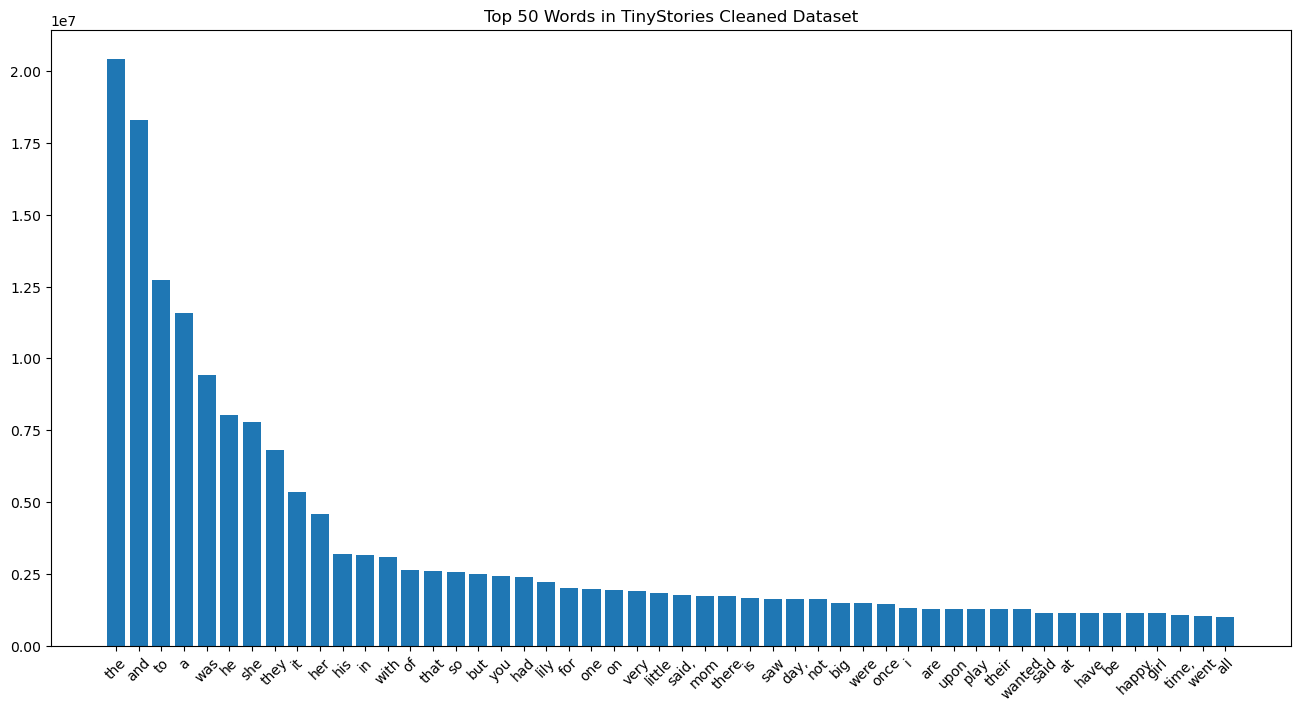

In [11]:
top_words = word_counter.most_common(50)
words, counts = zip(*top_words)

plt.figure(figsize=(16,8))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 50 Words in TinyStories Cleaned Dataset")
plt.show()


Then, check the symbol once more. make sure no emoji appear.

In [12]:
basic_pattern = re.compile(r"[a-zA-Z0-9\s]")

char_counter = Counter()

# Scan the dataset
for chunk in tqdm(pd.read_csv(CLEANED_DATASET, chunksize=CHUNKSIZE, engine="python"), desc="Scanning characters"):
    texts = chunk["text"].astype(str)
    joined = " ".join(texts)
    char_counter.update(joined)

# Extract all symbols and punctuation (non-alphanumeric, non-whitespace)
symbols_chars = {c: n for c, n in char_counter.items() if not basic_pattern.match(c)}

print("Symbols and Punctuation Detected:")
print("=" * 50)

# Sort by frequency (most common first)
for c, count in sorted(symbols_chars.items(), key=lambda x: x[1], reverse=True):
    # Show character, its ASCII/Unicode value, and frequency
    print(f"'{c}' (Unicode: {ord(c)}) : {count:,} times")

print(f"\nTotal unique symbols/punctuation: {len(symbols_chars)}")

# Check specifically for emojis and special symbols
print("\n" + "=" * 50)
print("EMOJI AND SPECIAL CHARACTER CHECK:")
print("=" * 50)

# Common emoji ranges in Unicode
emoji_ranges = [
    (0x1F600, 0x1F64F),  # Emoticons
    (0x1F300, 0x1F5FF),  # Symbols & Pictographs
    (0x1F680, 0x1F6FF),  # Transport & Map Symbols
    (0x1F700, 0x1F77F),  # Alchemical Symbols
    (0x1F780, 0x1F7FF),  # Geometric Shapes
    (0x1F800, 0x1F8FF),  # Supplemental Arrows-C
    (0x1F900, 0x1F9FF),  # Supplemental Symbols and Pictographs
    (0x2600, 0x26FF),    # Miscellaneous Symbols
    (0x2700, 0x27BF),    # Dingbats
    (0xFE00, 0xFE0F),    # Variation Selectors
]

found_emojis = {}

for char, count in symbols_chars.items():
    char_code = ord(char)
    
    # Check if character is in emoji ranges
    is_emoji = any(start <= char_code <= end for start, end in emoji_ranges)
    
    if is_emoji:
        found_emojis[char] = count
        print(f"EMOJI FOUND: '{char}' (Unicode: {char_code}) : {count:,} times")

if not found_emojis:
    print("No emojis found in the dataset!")
else:
    print(f"\nTotal emojis found: {len(found_emojis)}")

# Show character categories
print("\n" + "=" * 50)
print("CHARACTER CATEGORIES:")
print("=" * 50)

categories = {
    'Common Punctuation': [],
    'Quotes': [],
    'Math/Symbols': [],
    'Special/Other': [],
    'Possible Emojis': []
}

for char, count in symbols_chars.items():
    char_code = ord(char)
    
    # Categorize characters
    if char in '.,!?;:()[]{}-\'"`':
        categories['Common Punctuation'].append((char, count))
    elif char in '""''``""""':
        categories['Quotes'].append((char, count))
    elif char in '+-*/=<>@#$_&%~':
        categories['Math/Symbols'].append((char, count))
    elif any(start <= char_code <= end for start, end in emoji_ranges):
        categories['Possible Emojis'].append((char, count))
    else:
        categories['Special/Other'].append((char, count))

for category, chars in categories.items():
    if chars:
        print(f"\n{category}:")
        for char, count in sorted(chars, key=lambda x: x[1], reverse=True):
            print(f"  '{char}' (U+{ord(char):04X}) : {count:,}")

Scanning characters: 43it [01:05,  1.53s/it]

Symbols and Punctuation Detected:
'.' (Unicode: 46) : 36,820,282 times
',' (Unicode: 44) : 17,534,196 times
'"' (Unicode: 34) : 10,110,998 times
'!' (Unicode: 33) : 3,403,697 times
'?' (Unicode: 63) : 1,274,057 times
'-' (Unicode: 45) : 278,192 times
':' (Unicode: 58) : 152,984 times
';' (Unicode: 59) : 18,101 times
'“' (Unicode: 8220) : 10,772 times
'”' (Unicode: 8221) : 4,595 times
'/' (Unicode: 47) : 648 times
')' (Unicode: 41) : 391 times
'(' (Unicode: 40) : 376 times
'&' (Unicode: 38) : 100 times
'’' (Unicode: 8217) : 11 times
'…' (Unicode: 8230) : 7 times
'–' (Unicode: 8211) : 6 times
'‘' (Unicode: 8216) : 3 times

Total unique symbols/punctuation: 18

EMOJI AND SPECIAL CHARACTER CHECK:
No emojis found in the dataset!

CHARACTER CATEGORIES:

Common Punctuation:
  '.' (U+002E) : 36,820,282
  ',' (U+002C) : 17,534,196
  '"' (U+0022) : 10,110,998
  '!' (U+0021) : 3,403,697
  '?' (U+003F) : 1,274,057
  '-' (U+002D) : 278,192
  ':' (U+003A) : 152,984
  ';' (U+003B) : 18,101
  ')' (U+0